## 1. Detection

YOLOv8 _detection_ models have no suffix and are the default YOLOv8 models, i.e. `yolov8n.pt` and are pretrained on COCO. See [Detection Docs](https://docs.ultralytics.com/tasks/detect/) for full details.


In [1]:
import numpy as np

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.105 🚀 Python-3.10.11 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/107.7 GB disk)


In [3]:
# Load YOLOv8n, train it on COCO128 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('yolov8s.pt')  # load a pretrained YOLOv8n detection model
#model.train(data='coco128.yaml', epochs=1)  # train the model
res123 = model('https://ultralytics.com/images/bus.jpg', save_conf=True)  # predict on an image
# https://github.com/ultralytics/ultralytics/issues/1761


100%|██████████| 21.5M/21.5M [00:00<00:00, 73.9MB/s]

100%|██████████| 476k/476k [00:00<00:00, 19.9MB/s]
image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1114.5ms
Speed: 18.0ms preprocess, 1114.5ms inference, 30.6ms postprocess per image at shape (1, 3, 640, 640)


@happydracula @glenn-jocher
I tried doing save_conf=True, but there wasn't anything. However this is what I did at the end though:

** Inference**

results: Results = model(frame, imgsz=input_size)[0]

**Get all the classes**

classes: Dict[int, str] = results.names

**From the boxes get the predictions**

results_with_probs: List[Tuple[Results, str]] = [(result, classes[result.boxes.cls.numpy()[0]]) for result in results]


It seems that model(frame, imgsz=input_size) outputs a list. BUT even with multiple detection boxes, it's always one size list. So the way I did it was access the result.boxes.cls this is a pytorch tensor 1xN where N is number of detections for the index of results.names. So you would get the index from result.boxes.cls and then map it to results.names.

In [4]:
from typing import Dict, List, Tuple, Any

Results = ultralytics.yolo.engine.results.Results

# https://github.com/ultralytics/ultralytics/issues/1761#issuecomment-1498525593
# https://docs.python.org/3/library/typing.html

In [5]:
# Inference
results: Results = res123[0].cpu()

# Get all the classes
classes: Dict[int, str] = results.names

# From the boxes get the predictions
results_with_probs: List[Tuple[Results, str]] = [(result, tuple[classes[result.boxes.cls.numpy()[0]], result.boxes.conf.numpy()[0]]) for result in results]

In [6]:
classes[results[0].boxes.cls.numpy()[0]]

'bus'

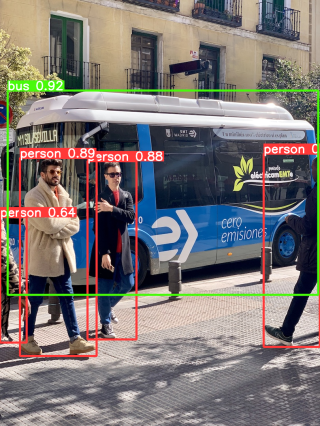

tuple['bus', 0.9202174]


In [12]:
# !pip install imutils
import cv2, imutils
from google.colab.patches import cv2_imshow
img_S = imutils.resize(res123[0].plot(probs = True, boxes = True), width=320)
cv2_imshow(img_S)
print(results_with_probs[0][-1])

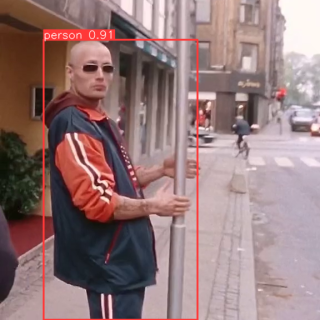

tuple['person', 0.91279095]


In [ ]:
img_S = imutils.resize(results_with_probs[0][0].plot(probs = True, boxes = True), width=320)
cv2_imshow(img_S)
print(results_with_probs[0][-1])

In [ ]:
len(results_with_probs)

6

In [ ]:
np.unique(res123[0].cpu().boxes.cls.numpy())

res_numpy = (res123[0].cpu().boxes.cls.numpy().astype(int))

In [ ]:
res_numpy

array([5, 0, 0, 0, 0])

## Usage with video:

https://docs.ultralytics.com/modes/predict/

In [ ]:
import os
filename = "tonylife2.mp4"
filepath = "/content/" + filename
if os.path.exists(filepath):
  print("exist")

exist


In [ ]:
# https://ffmpeg.org/ffprobe.html

import subprocess
import json
import re

def extract_metadata(video_file):
    command = ['ffprobe', '-v', 'error', '-show_entries', 'stream', '-of', 'json', video_file]
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if result.returncode == 0:
        metadata = json.loads(result.stdout.decode('utf-8'))
        return metadata
    else:
        error_message = result.stderr.decode('utf-8').strip()
        raise Exception(f'Error running ffprobe: {error_message}')

# Example usage
metadata = extract_metadata(filepath)
codec_name = metadata['streams'][0]['codec_name']
print('Codec_name:', codec_name)
duration = float(metadata['streams'][0]['duration'])
print('Duration:', duration)
frames = int(metadata['streams'][0]['nb_frames'])
print('Frames:', frames)
width = metadata['streams'][0]['width']
height = metadata['streams'][0]['height']
print('Resolution:', metadata['streams'][0]['width'], 'x', metadata['streams'][0]['height'])
frame_rate = int(re.search(r'\d+', metadata['streams'][0]['avg_frame_rate']).group())
print('Frame rate:', frame_rate)


Codec_name: h264
Duration: 9.740741
Frames: 263
Resolution: 576 x 576
Frame rate: 27


In [ ]:
# import subprocess

# def extract_metadata(video_file):
#     command = ['ffprobe', '-v', 'error', '-show_entries', 'stream', '-of', 'json', video_file]
#     result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     if result.returncode == 0:
#         metadata = result.stdout.decode('utf-8')
#         return metadata
#     else:
#         error_message = result.stderr.decode('utf-8').strip()
#         raise Exception(f'Error running ffprobe: {error_message}')

# # Example usage
# metadata = extract_metadata(filepath)
# print(metadata)


In [ ]:
import os
if os.path.exists(filepath):
  model_results = model.predict(source = filepath, 
                          save=True, 
                          vid_stride=10, 
                          #imgsz= max(width, height), 
                          imgsz = 320,
                          conf=0.3,
                          #half = True,
                          save_txt = True,
                          save_conf = True,
                          )
  boxes = []
  probs = []
  for r in model_results:
    boxes.append(r.boxes)  # Boxes object for bbox outputs
    probs.append(r.probs)  # Class probabilities for classification outputs
print(len(model_results))



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/26) /content/tonylife2.mp4: 320x320 2 persons, 2 cars, 1 potted plant, 228.8ms
video 1/1 (2/26) /content/tonylife2.mp4: 320x320 5 persons, 219.6ms
video 1/1 (3/26) /content/tonylife2.mp4: 320x320 3 persons, 140.4ms
video 1/1 (4/26) /content/tonylife2.mp4: 320x320 3 persons, 133.5ms
video 1/1 (5/26) /content/tonylife2.mp4: 320x320 2 persons, 1 bicycle, 1 car, 138.6ms
video 1/1 (6/26) /content/tonylife2.mp4: 320x320 2 persons, 1 bicycle, 2 cars

26


In [ ]:
boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️

[ultralytics.yolo.engine.results.Boxes object with attributes:
 
 boxes: tensor([[6.5355e+01, 6.5583e+01, 3.7552e+02, 5.7523e+02, 9.4226e-01, 0.0000e+00],
         [4.5199e+02, 2.1377e+02, 4.8371e+02, 2.9057e+02, 6.8178e-01, 0.0000e+00],
         [3.6692e+02, 2.1683e+02, 4.8080e+02, 2.6743e+02, 5.7015e-01, 2.0000e+00],
         [3.6780e+02, 2.1678e+02, 5.4473e+02, 2.6938e+02, 4.5031e-01, 2.0000e+00],
         [1.7715e-01, 2.4010e+02, 9.3162e+01, 5.1913e+02, 3.8073e-01, 5.8000e+01]])
 cls: tensor([ 0.,  0.,  2.,  2., 58.])
 conf: tensor([0.9423, 0.6818, 0.5701, 0.4503, 0.3807])
 data: tensor([[6.5355e+01, 6.5583e+01, 3.7552e+02, 5.7523e+02, 9.4226e-01, 0.0000e+00],
         [4.5199e+02, 2.1377e+02, 4.8371e+02, 2.9057e+02, 6.8178e-01, 0.0000e+00],
         [3.6692e+02, 2.1683e+02, 4.8080e+02, 2.6743e+02, 5.7015e-01, 2.0000e+00],
         [3.6780e+02, 2.1678e+02, 5.4473e+02, 2.6938e+02, 4.5031e-01, 2.0000e+00],
         [1.7715e-01, 2.4010e+02, 9.3162e+01, 5.1913e+02, 3.8073e-01, 5.8000e+

In [ ]:
len(results)

NameError: ignored

In [ ]:
results[4].boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[7.9216e+01, 1.2761e+02, 5.7477e+02, 5.7513e+02, 9.3997e-01, 0.0000e+00],
        [6.4119e-01, 2.8700e+02, 9.6235e+01, 5.7462e+02, 7.4048e-01, 0.0000e+00],
        [7.0094e-01, 1.3100e+02, 9.4596e+01, 5.7413e+02, 5.9188e-01, 0.0000e+00],
        [4.6657e+02, 2.3365e+02, 4.9202e+02, 3.2133e+02, 3.1387e-01, 0.0000e+00]])
cls: tensor([0., 0., 0., 0.])
conf: tensor([0.9400, 0.7405, 0.5919, 0.3139])
data: tensor([[7.9216e+01, 1.2761e+02, 5.7477e+02, 5.7513e+02, 9.3997e-01, 0.0000e+00],
        [6.4119e-01, 2.8700e+02, 9.6235e+01, 5.7462e+02, 7.4048e-01, 0.0000e+00],
        [7.0094e-01, 1.3100e+02, 9.4596e+01, 5.7413e+02, 5.9188e-01, 0.0000e+00],
        [4.6657e+02, 2.3365e+02, 4.9202e+02, 3.2133e+02, 3.1387e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: tensor([576, 576])
shape: torch.Size([4, 6])
xywh: tensor([[326.9937, 351.3717, 495.5551, 447.5172],
        [ 48.4383, 430.8094,  95.5942, 287.6272],
 

In [ ]:
# import shutil

# shutil.copyfile(src, dst)

# # 2nd option
# shutil.copy(src, dst)  # dst can be a folder; use shutil.copy2() to preserve timestamp

In [ ]:
print(results[0].boxes)

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[7.1261e+01, 8.4652e+01, 3.4398e+02, 5.7563e+02, 9.4501e-01, 0.0000e+00],
        [5.3943e+02, 2.1373e+02, 5.7561e+02, 2.5461e+02, 7.7697e-01, 2.0000e+00],
        [4.0047e+02, 2.1344e+02, 4.3305e+02, 2.7515e+02, 7.4481e-01, 0.0000e+00],
        [5.0387e+02, 2.0670e+02, 5.4746e+02, 2.4596e+02, 7.0932e-01, 2.0000e+00],
        [4.0221e+02, 2.5262e+02, 4.3336e+02, 2.9491e+02, 6.1855e-01, 1.0000e+00],
        [2.1944e-01, 3.0879e+02, 5.1007e+01, 5.5968e+02, 5.0438e-01, 0.0000e+00]], device='cuda:0')
cls: tensor([0., 2., 0., 2., 1., 0.], device='cuda:0')
conf: tensor([0.9450, 0.7770, 0.7448, 0.7093, 0.6185, 0.5044], device='cuda:0')
data: tensor([[7.1261e+01, 8.4652e+01, 3.4398e+02, 5.7563e+02, 9.4501e-01, 0.0000e+00],
        [5.3943e+02, 2.1373e+02, 5.7561e+02, 2.5461e+02, 7.7697e-01, 2.0000e+00],
        [4.0047e+02, 2.1344e+02, 4.3305e+02, 2.7515e+02, 7.4481e-01, 0.0000e+00],
        [5.0387e+02, 2.0670e+02, 

idx: [0]


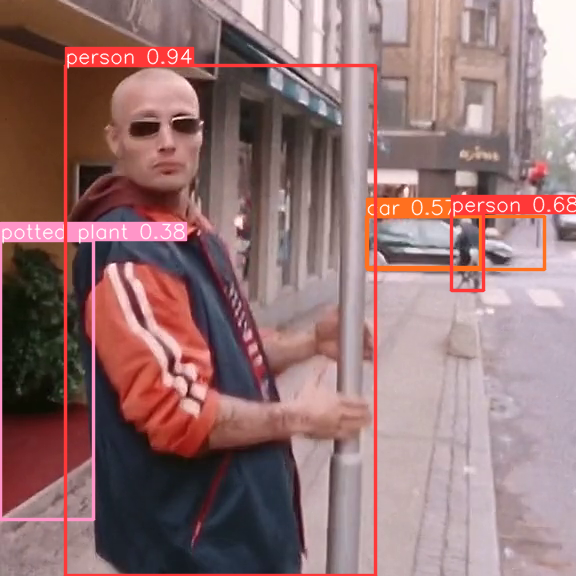

idx: [10]


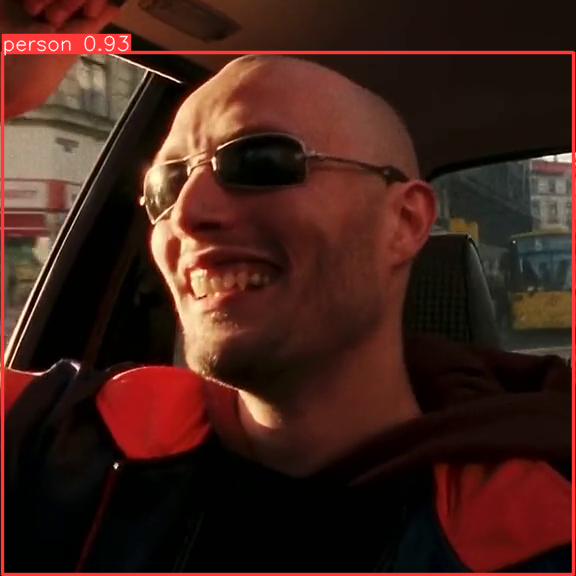

idx: [20]


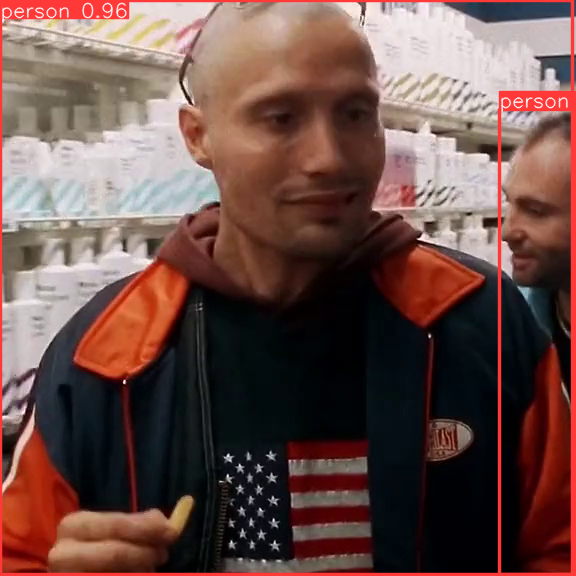

In [ ]:
from google.colab.patches import cv2_imshow


for idx, r in enumerate(model_results):
  if not idx%10: 
    print(f"idx: [{idx}]")
    cv2_imshow(r.plot())
    
  if idx == 100: break

## Deprecated preprocess, DO NOT USE!

In [ ]:
test_string = "0 0.67776 0.515029 0.495245 0.952249 0.938609\n0 0.350664 0.577573 0.310164 0.840977 0.930994\n2 0.112338 0.628538 0.223306 0.536252 0.855141\n"

# https://www.geeksforgeeks.org/python-extract-numbers-from-string/

print("The original string : " + test_string)

res = list(filter(lambda x: x.isdigit(), test_string.split()))

print(res)

# use a list comprehension to convert the remaining elements to integers
res = [int(s) for s in res]

# print the resulting list of integers
print("The numbers list is : " + str(res))


The original string : 0 0.67776 0.515029 0.495245 0.952249 0.938609
0 0.350664 0.577573 0.310164 0.840977 0.930994
2 0.112338 0.628538 0.223306 0.536252 0.855141

['0', '0', '2']
The numbers list is : [0, 0, 2]


In [ ]:
# https://stackoverflow.com/questions/4289331/how-to-extract-numbers-from-a-string-in-python

import os
import re

def extract_numbers(filename):
    return int(re.search(r'\d+', filename).group())

def get_objects_names_by_frames(folder_path, include_ids = False):
    filenames = os.listdir(folder_path)
    sorted_filenames = sorted(filenames, key=extract_numbers)
    
    class_names = []
    class_ids = []
    
    for filename in sorted_filenames:
        vectors_names = []
        vectors_id = []
        #print(filename)
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                line = list(filter(lambda x: x.isdigit(), line.strip().split()))

                vector_id = [int(s) for s in line]
                vector_name = [model.names[int(s)] for s in line]
                
                vectors_names.append(vector_name)
                vectors_id.append(vector_id)

        class_names.append(vectors_names)
        class_ids.append(vectors_id)

    if (include_ids): return class_ids, class_names
    return class_names
    

folder_path = '/content/runs/detect/predict/labels'
object_names_by_frame = get_objects_names_by_frames(folder_path)
print(object_names_by_frame)
print(len(object_names_by_frame))
print(object_names_by_frame[1])

[[['person'], ['car']], [['person'], ['person'], ['person'], ['person'], ['potted plant']], [['car'], ['person'], ['person'], ['person']], [['person']], [['person'], ['car']], [['person'], ['car']], [['person'], ['car']], [['person']], [['person'], ['car']], [['person'], ['umbrella']], [['person'], ['person'], ['person']], [['person'], ['car'], ['person'], ['car'], ['potted plant'], ['bicycle']], [['person']], [['person']], [['person']], [['person']], [['person'], ['person'], ['potted plant']], [['person'], ['umbrella']], [['person'], ['umbrella']], [['person'], ['bicycle'], ['car'], ['car'], ['person']], [['person'], ['car']], [['person']], [['person']], [['person']], [['person'], ['person']], [['person']], [['person'], ['toothbrush'], ['toothbrush'], ['toothbrush']], [['person']], [['person'], ['car'], ['car'], ['car']], [['person'], ['car'], ['person']], [['car'], ['person'], ['person']], [['person']], [['person']], [['person']], [['person']], [['person'], ['car']], [['person'], ['p

In [ ]:
# Sample 2D list
#items = [['apple', 'orange', 'banana'], ['orange', 'grape'], ['banana', 'apple', 'kiwi']]

items = object_names_by_frame

# Initialize an empty dictionary to hold the items
item_dict = {}

# Loop through each sublist in the 2D list
for sublist in items:
    print(sublist)
    # Loop through each item in the sublist
    for item in sublist:
        print(item)
        # Check if the item is already in the dictionary
        if item[0] not in item_dict:
            # If not, add it with a value of 1
            item_dict[item[0]] = 1
        else:
            # If it is, increment the value by 1
            item_dict[item[0]] += 1

# Print the unique items
unique_items = set(item_dict.keys())
print(unique_items)


[['person'], ['car']]
['person']
['car']
[['person'], ['person'], ['person'], ['person'], ['potted plant']]
['person']
['person']
['person']
['person']
['potted plant']
[['car'], ['person'], ['person'], ['person']]
['car']
['person']
['person']
['person']
[['person']]
['person']
[['person'], ['car']]
['person']
['car']
[['person'], ['car']]
['person']
['car']
[['person'], ['car']]
['person']
['car']
[['person']]
['person']
[['person'], ['car']]
['person']
['car']
[['person'], ['umbrella']]
['person']
['umbrella']
[['person'], ['person'], ['person']]
['person']
['person']
['person']
[['person'], ['car'], ['person'], ['car'], ['potted plant'], ['bicycle']]
['person']
['car']
['person']
['car']
['potted plant']
['bicycle']
[['person']]
['person']
[['person']]
['person']
[['person']]
['person']
[['person']]
['person']
[['person'], ['person'], ['potted plant']]
['person']
['person']
['potted plant']
[['person'], ['umbrella']]
['person']
['umbrella']
[['person'], ['umbrella']]
['person']
['u

In [ ]:
item_dict["handbag"]

1

In [ ]:
item_dict

{'person': 414,
 'car': 122,
 'potted plant': 10,
 'umbrella': 18,
 'bicycle': 20,
 'toothbrush': 11,
 'bus': 2,
 'traffic light': 2,
 'handbag': 1,
 'bottle': 11,
 'tie': 2,
 'wine glass': 1}

In [ ]:
import numpy as np
new_list = []

for i in object_names_by_frame:
  new_list.append(np.array(i).flatten())
print(new_list)

# deasfadfad = np.array(object_names_by_frame).flatten()
print(np.unique(new_list))

[array(['person', 'car'], dtype='<U6'), array(['person', 'person', 'person', 'person', 'potted plant'], dtype='<U12'), array(['car', 'person', 'person', 'person'], dtype='<U6'), array(['person'], dtype='<U6'), array(['person', 'car'], dtype='<U6'), array(['person', 'car'], dtype='<U6'), array(['person', 'car'], dtype='<U6'), array(['person'], dtype='<U6'), array(['person', 'car'], dtype='<U6'), array(['person', 'umbrella'], dtype='<U8'), array(['person', 'person', 'person'], dtype='<U6'), array(['person', 'car', 'person', 'car', 'potted plant', 'bicycle'], dtype='<U12'), array(['person'], dtype='<U6'), array(['person'], dtype='<U6'), array(['person'], dtype='<U6'), array(['person'], dtype='<U6'), array(['person', 'person', 'potted plant'], dtype='<U12'), array(['person', 'umbrella'], dtype='<U8'), array(['person', 'umbrella'], dtype='<U8'), array(['person', 'bicycle', 'car', 'car', 'person'], dtype='<U7'), array(['person', 'car'], dtype='<U6'), array(['person'], dtype='<U6'), array(['p

/usr/local/lib/python3.9/dist-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


ValueError: ignored

In [ ]:
for r in results:
    boxes = r.boxes  # Boxes object for bbox outputs
    probs = r.probs  # Class probabilities for classification outputs

## Run

In [ ]:

#@title ← Run <center> </font> <font color='red'> FFMPEG Compress <img src='https://dashboard.snapcraft.io/site_media/appmedia/2018/07/ffmpeg_LvkKa6R.png' height="40" /> </center> { display-mode: "form" }
import os
input_Video = f"/content/runs/detect/predict/{filename}" #@param {type:"string"}
Download_location = "/content/result_compressed.mp4" #@param {type:"string"}

crf = 22 #@param {type:"slider", min:17, max:28, step:1}
#@markdown <font color='greenr'> Recommended crf = "28" </font>

#@markdown CRF - [Lower(17) = Higher Quality/Larger File Size] 

#@markdown CRF - [Higher(28) = Normal Quality/small File Size] 


!ffmpeg -i "$input_Video" -vcodec libx264 -crf "$crf" -preset "veryfast" "$Download_location"

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
#@title Old display code for Colab
# !apt install ffmpeg

# from IPython.display import HTML
# from base64 import b64encode
# import os

# # Input video path
# save_path = "/content/Get your d out Waltuh.mp4"

# # Compressed video path
# compressed_path = "/content/result_compressed.mp4"

# os.system(f"ffmpeg -i {save_path} -vcodec libx264 -preset "veryfast" {compressed_path}")

# # Show video
# mp4 = open(compressed_path,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=400 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)

In [ ]:
#!pip install moviepy
import moviepy.editor

import os
input_Video = f"/content/runs/detect/predict/{filename}" #@param {type:"string"}
Download_location = "/content/result_compressed.mp4" #@param {type:"string"}

crf = 22 

!ffmpeg -i "$input_Video" -vcodec libx264 -crf "$crf" -preset "veryfast" "$Download_location"

result_filepath = "/content/result_compressed.mp4"
moviepy.editor.ipython_display(result_filepath)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
# https://tproger.ru/translations/implementing-zip-list-comprehensions/
# Inference
#results: Results = model_results[0].cpu()

# Get all the classes
classes: Dict[int, str] = model_results[0].names

classes_names_list = [ [ classes[cls] for cls in result.boxes.cls.numpy() ] for result in model_results]
conf_list = [ result.boxes.conf.numpy() for result in model_results] 

classes_and_confs = list(zip(classes_names_list, conf_list))
print(classes_and_confs)

# From the boxes get the predictions
#results_with_probs: List[Tuple[Results, Tuple[str]]] = [(result, tuple[[(classes[cls]) for cls in result.boxes.cls.numpy()], result.boxes.conf.numpy()]) for result in model_results]

[(['person', 'person', 'car', 'car', 'potted plant'], array([    0.94226,     0.68178,     0.57015,     0.45031,     0.38073], dtype=float32)), (['person', 'person', 'person', 'person', 'person'], array([    0.92097,     0.76004,     0.60904,     0.53464,     0.52571], dtype=float32)), (['person', 'person', 'person'], array([    0.95231,     0.82341,     0.40177], dtype=float32)), (['person', 'person', 'person'], array([    0.92378,     0.88218,     0.54201], dtype=float32)), (['person', 'person', 'car', 'bicycle'], array([    0.93756,     0.83337,     0.37759,     0.30686], dtype=float32)), (['person', 'car', 'bicycle', 'person', 'car'], array([    0.94561,     0.74328,     0.72301,     0.42082,     0.36147], dtype=float32)), (['person'], array([    0.95787], dtype=float32)), (['person', 'car'], array([    0.93354,     0.44849], dtype=float32)), (['person'], array([    0.95325], dtype=float32)), (['person'], array([     0.9476], dtype=float32)), (['person'], array([    0.92503], dtype

In [ ]:
print(conf_list[0])
print(classes_names_list[0])
print(classes_and_confs[0])

[    0.94226     0.68178     0.57015     0.45031     0.38073]
['person', 'person', 'car', 'car', 'potted plant']
(['person', 'person', 'car', 'car', 'potted plant'], array([    0.94226,     0.68178,     0.57015,     0.45031,     0.38073], dtype=float32))


In [ ]:
print(classes_and_meconfs[0][1][0])

0.9422638


In [ ]:
model_results[0].boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[6.5355e+01, 6.5583e+01, 3.7552e+02, 5.7523e+02, 9.4226e-01, 0.0000e+00],
        [4.5199e+02, 2.1377e+02, 4.8371e+02, 2.9057e+02, 6.8178e-01, 0.0000e+00],
        [3.6692e+02, 2.1683e+02, 4.8080e+02, 2.6743e+02, 5.7015e-01, 2.0000e+00],
        [3.6780e+02, 2.1678e+02, 5.4473e+02, 2.6938e+02, 4.5031e-01, 2.0000e+00],
        [1.7715e-01, 2.4010e+02, 9.3162e+01, 5.1913e+02, 3.8073e-01, 5.8000e+01]])
cls: tensor([ 0.,  0.,  2.,  2., 58.])
conf: tensor([0.9423, 0.6818, 0.5701, 0.4503, 0.3807])
data: tensor([[6.5355e+01, 6.5583e+01, 3.7552e+02, 5.7523e+02, 9.4226e-01, 0.0000e+00],
        [4.5199e+02, 2.1377e+02, 4.8371e+02, 2.9057e+02, 6.8178e-01, 0.0000e+00],
        [3.6692e+02, 2.1683e+02, 4.8080e+02, 2.6743e+02, 5.7015e-01, 2.0000e+00],
        [3.6780e+02, 2.1678e+02, 5.4473e+02, 2.6938e+02, 4.5031e-01, 2.0000e+00],
        [1.7715e-01, 2.4010e+02, 9.3162e+01, 5.1913e+02, 3.8073e-01, 5.8000e+01]])
id: None

In [ ]:
results_with_probs[0].boxes()

AttributeError: ignored

In [ ]:
len(results_with_probs)

26

In [ ]:
model_results[0].names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [ ]:
print(len(results))
print(len(model_results))

6
263


In [ ]:
class_names = [(classes[result[0].boxes.cls.numpy()]) for result in results]
print(class_names)

TypeError: ignored

In [ ]:
np.unique(res123[0].cpu().boxes.cls.numpy())

res_numpy = (res123[0].cpu().boxes.cls.numpy().astype(int))

In [ ]:
res_numpy

array([5, 0, 0, 0, 0])

### Функція яка бере на вхід шлях до відосу. 
### На виході дає results з дописаними пробабілітсами, також окремо вертає кортеж з класами і ймовірностями. Відос оброблений сохраняє

In [ ]:
def preprocess_video(filepath: str, stride: int, resize: int = 0) -> :

import numpy as np


def init_model():



def preprocess_video(filepath: str, stride: int, resize: int = 0) -> :

  